In [27]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime

In [28]:
# Load the dataset
df = pd.read_csv('TSLA.csv')

end_date = datetime.datetime.now() 
start_date = end_date - datetime.timedelta(days = 365 * 5)
stock_data = yf.download('TSLA', start=start_date.date(), end=end_date.date())

# Use only the 'Close' column
data = pd.DataFrame(stock_data[['Open', 'Close', 'High', 'Low']].values, columns=['Open', 'Close', 'High', 'Low'])

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 1])
    return np.array(dataX), np.array(dataY)

# Define time step and split data
time_step = 100
X, y = create_dataset(scaled_data, time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Reshape input to be [samples, time steps, features]
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 4)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 4)

[*********************100%***********************]  1 of 1 completed
(924, 100, 4)
(232, 100, 4)
(924,)
(232,)


In [29]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 4)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
15/15 [==============================] - 6s 159ms/step - loss: 0.0703 - val_loss: 0.0088
Epoch 2/100
15/15 [==============================] - 1s 99ms/step - loss: 0.0106 - val_loss: 0.0068
Epoch 3/100
15/15 [==============================] - 1s 96ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 4/100
15/15 [==============================] - 1s 96ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 5/100
15/15 [==============================] - 1s 94ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 6/100
15/15 [==============================] - 1s 97ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/100
15/15 [==============================] - 1s 97ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 8/100
15/15 [==============================] - 1s 97ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 9/100
15/15 [==============================] - 1s 95ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 10/100
15/15 [==============================] - 1s 94ms/step - loss: 0.0019 - val_loss: 0.001

In [55]:
predictions = model.predict(X_test)
print (predictions.shape)
temp = scaled_data[-232:]
temp[:, 1] = predictions.reshape(-1)
temp = scaler.inverse_transform(temp) # Undo scaling
predictions = temp[-232:, 1]

8/8 [==============================] - 0s 23ms/step
(232, 1)


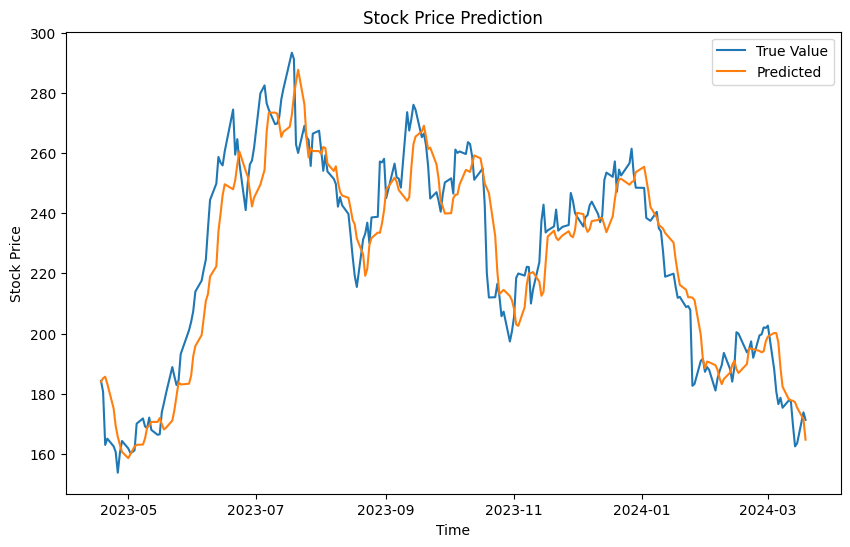

In [56]:
# plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='True Value')

# plt.plot(predictions, label='Predicted')


# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(stock_data.index[-232:], stock_data['Close'].tail(232), label='True Value')
plt.plot(stock_data.index[-232:], predictions, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
